In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Data from https://github.com/GregaVrbancic/Phishing-Dataset

In [2]:
df = pd.read_csv("data/dataset_full.csv")
df

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


### Exploratory Data Analysis

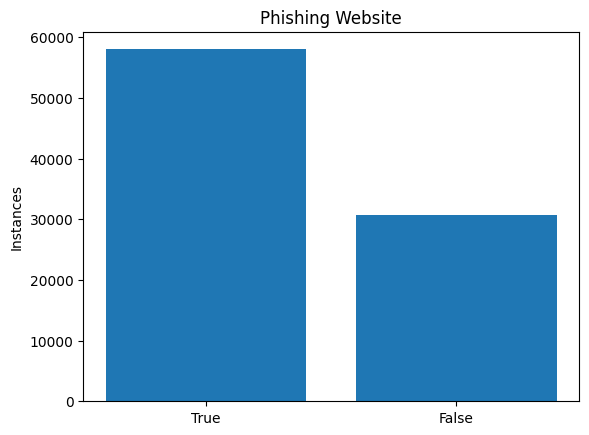

In [3]:
plt.bar(["True", "False"], df['phishing'].value_counts())
plt.title("Phishing Website")
plt.ylabel("Instances")
plt.show()

In [4]:
phish_true = df[df['phishing'] == True]
phish_false = df[df['phishing'] == False]

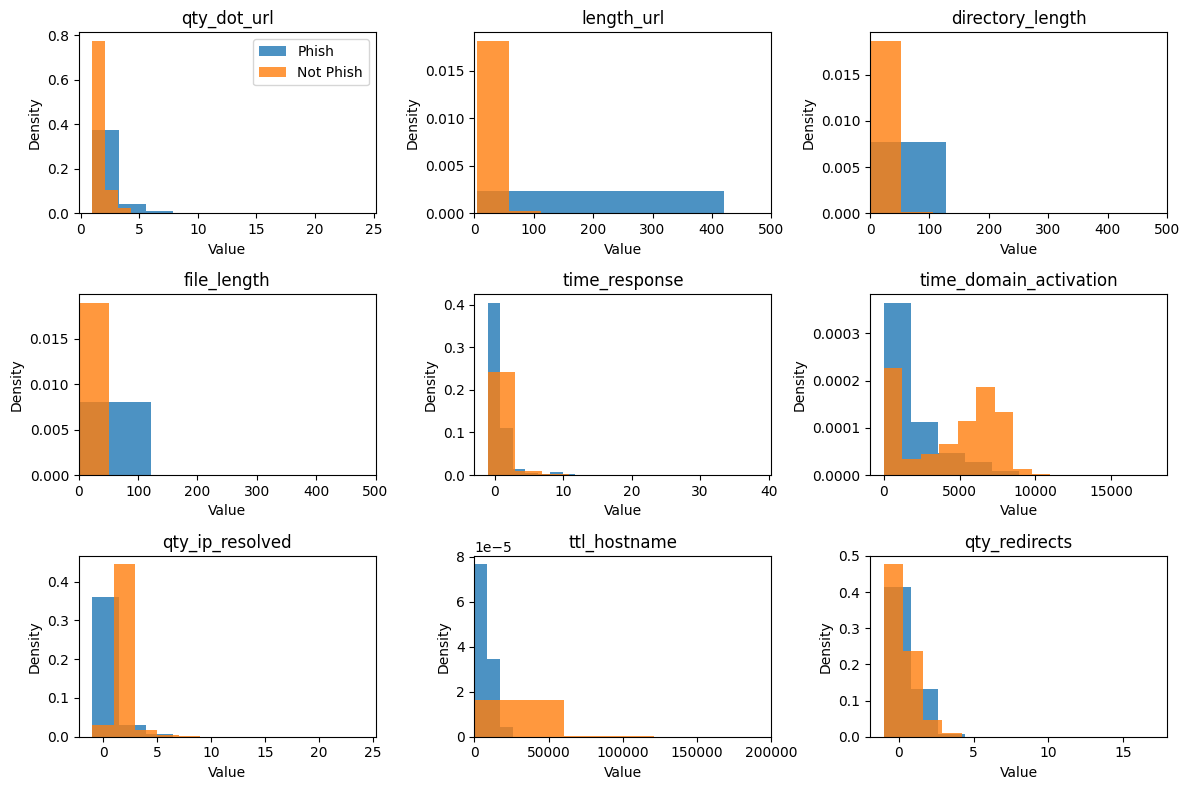

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = axs.flatten()
columns = ['qty_dot_url', 'length_url', 'directory_length', 'file_length', 'time_response', 'time_domain_activation', 'qty_ip_resolved', 'ttl_hostname', 'qty_redirects']
for i, ax in enumerate(axs):
    column = columns[i]
    ax.hist(phish_true[column], density=True, label="Phish", alpha=0.8)
    ax.hist(phish_false[column], density=True, label="Not Phish", alpha=0.8)
    ax.set_title(column)
    ax.set_ylabel("Density")
    ax.set_xlabel("Value")
    if i == 0:
        ax.legend()
    if 'length' in column:
        ax.set_xlim(0, 500)
    if 'ttl_hostname' in column:
        ax.set_xlim(0, 2e5)
plt.tight_layout()
plt.show()


### Setting up

In [6]:
from sklearn.model_selection import train_test_split

x = df.drop(labels='phishing', axis=1)
y = df['phishing']
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1, random_state=19)

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate(model, model_name):
    fig, axs = plt.subplots(1, 2)
    axs = axs.flatten()

    ## training accuracy
    train_pred = model.predict(train_x)
    print("%s Train Accuracy %.3f" % (model_name, accuracy_score(train_y, train_pred)))
    confusion = confusion_matrix(train_y, train_pred, normalize='true')
    ConfusionMatrixDisplay(confusion).plot(ax=axs[0], colorbar=False, cmap='Blues')
    axs[0].set_title("Train Data")
    # plt.show()

    test_pred = model.predict(test_x)
    print("%s Test Accuracy %.3f" % (model_name, accuracy_score(test_y, test_pred)))
    confusion = confusion_matrix(test_y, test_pred, normalize='true')
    ConfusionMatrixDisplay(confusion).plot(ax=axs[1], colorbar=False, cmap='Blues')
    axs[1].set_title("Test Data")

    plt.suptitle(model_name)
    plt.tight_layout()
    plt.show()


# First Results

KNN Train Accuracy 0.917
KNN Test Accuracy 0.879


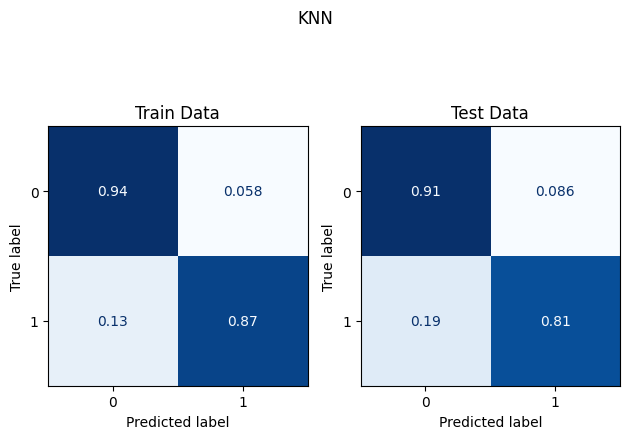

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(train_x, train_y)
evaluate(knn_model, "KNN")

Logistic Regression Train Accuracy 0.913
Logistic Regression Test Accuracy 0.913


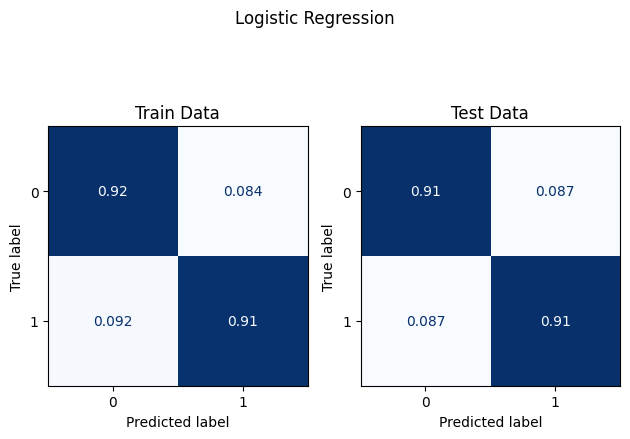

In [9]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=10000)
log_model.fit(train_x, train_y)
evaluate(log_model, "Logistic Regression")

Linear SVM Train Accuracy 0.847
Linear SVM Test Accuracy 0.844


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


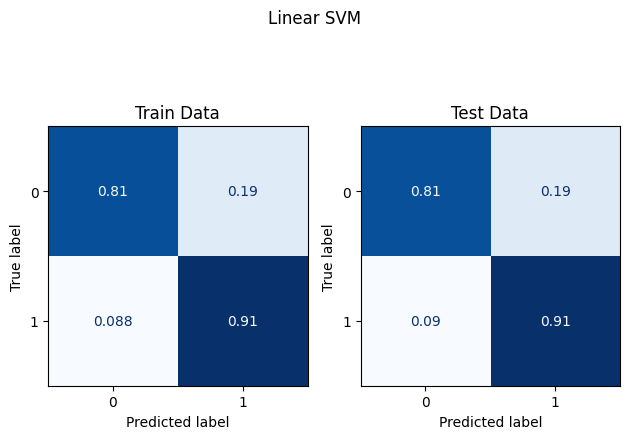

In [10]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC()
linear_svm.fit(train_x, train_y)
evaluate(linear_svm, "Linear SVM")

Decision Tree Train Accuracy 0.936
Decision Tree Test Accuracy 0.935


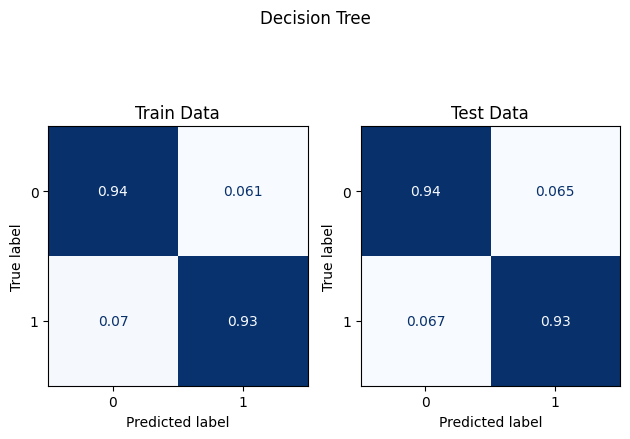

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

decision_tree = DecisionTreeClassifier(max_depth=5)
decision_tree.fit(train_x, train_y)
evaluate(decision_tree, "Decision Tree")

### Decision Tree Feature Selection

In [12]:
from heapq import nlargest

importances = decision_tree.feature_importances_

feature_importance = {}
for i, feature in enumerate(x.columns.values.tolist()):
    feature_importance[feature] = round(importances[i], 3)

#print(f"Feature importance: {feature_importance}")

sorted = nlargest(5, feature_importance, key = feature_importance.get)
print("Top 5 features: " + str(sorted))

Top 5 features: ['directory_length', 'time_domain_activation', 'qty_percent_file', 'qty_dot_domain', 'time_response']


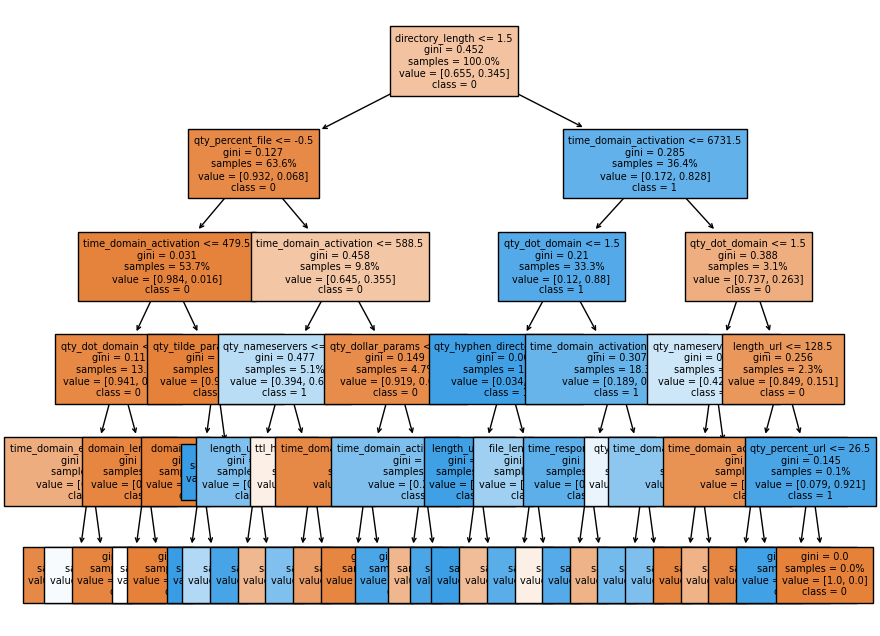

In [13]:
features = x.columns.values.tolist()
classes = ["0", "1"]

plt.figure(figsize=(10, 8))
plot_tree(decision_tree,
          feature_names=features,
          class_names=classes,
          filled=True,
          proportion=True,
          fontsize = 7)
plt.show()

Naive Bayes Train Accuracy 0.843
Naive Bayes Test Accuracy 0.833


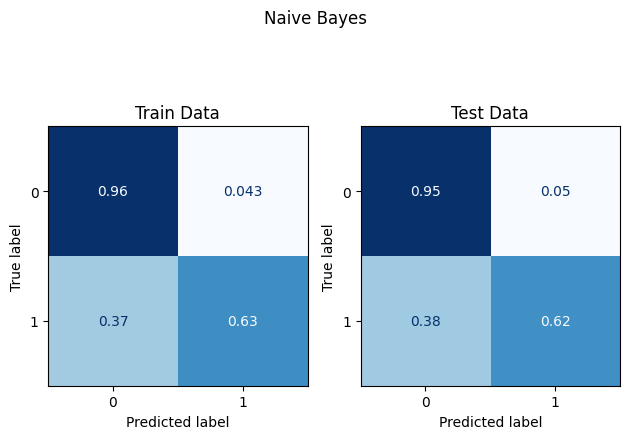

In [14]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(train_x, train_y)
evaluate(naive_bayes, "Naive Bayes")

### Naive Bayes Feature Selection

In [15]:
from sklearn.inspection import permutation_importance 

imps = permutation_importance(naive_bayes, test_x, test_y)
#print(imps.importances_mean)

for i in imps.importances_mean.argsort()[::1]:
    if imps.importances_mean[i] - 2 * imps.importances_std[i] > 0:
        print(f"{x.columns.values.tolist()[i]}"
        f"\t{imps.importances_mean[i]:.3f}"
        f" +/- {imps.importances_std[i]:.3f}")

domain_spf	0.000 +/- 0.000
qty_nameservers	0.001 +/- 0.000
qty_dot_domain	0.001 +/- 0.000
qty_percent_directory	0.001 +/- 0.000
qty_percent_file	0.001 +/- 0.000
qty_hyphen_directory	0.002 +/- 0.000
qty_underline_directory	0.002 +/- 0.000
qty_hyphen_file	0.002 +/- 0.000
qty_underline_file	0.002 +/- 0.000
qty_equal_directory	0.002 +/- 0.000
qty_exclamation_file	0.002 +/- 0.000
qty_exclamation_directory	0.002 +/- 0.000
qty_equal_file	0.002 +/- 0.000
qty_and_file	0.002 +/- 0.000
qty_asterisk_directory	0.002 +/- 0.000
qty_and_directory	0.002 +/- 0.000
qty_tilde_directory	0.002 +/- 0.000
qty_asterisk_file	0.002 +/- 0.000
qty_at_directory	0.002 +/- 0.000
qty_space_file	0.002 +/- 0.000
qty_space_directory	0.002 +/- 0.000
qty_dollar_file	0.002 +/- 0.000
qty_hashtag_file	0.002 +/- 0.000
qty_questionmark_directory	0.002 +/- 0.000
qty_comma_directory	0.002 +/- 0.000
qty_plus_directory	0.002 +/- 0.000
qty_hashtag_directory	0.002 +/- 0.000
qty_slash_file	0.002 +/- 0.000
qty_questionmark_file	0.002 +

AdaBoost Train Accuracy 0.936
AdaBoost Test Accuracy 0.931


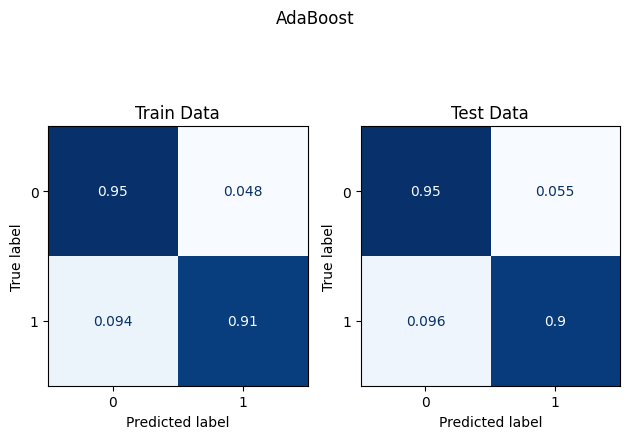

In [16]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier()
adaboost.fit(train_x, train_y)
evaluate(adaboost, "AdaBoost")

MLP Train Accuracy 0.821
MLP Test Accuracy 0.818


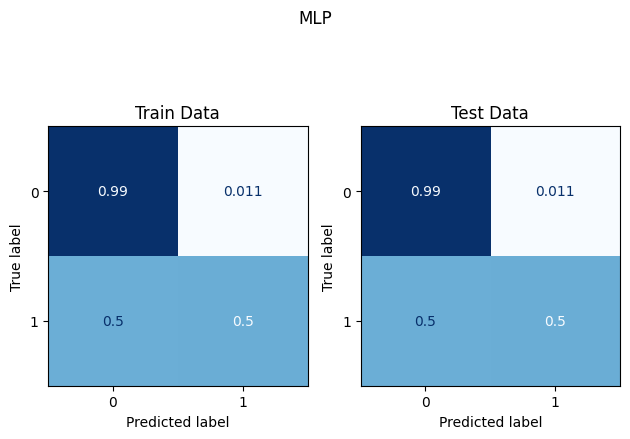

In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(train_x, train_y)
evaluate(mlp, "MLP")